In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import h5py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from uatu.scattering import *
from kymatio import Scattering2D

In [5]:
from scipy import fftpack
from scipy.ndimage import gaussian_filter
import numpy as np
import pylab as py
#import radialProfile
from scipy.fftpack import fft2

In [6]:
model_path = '/home/sean/Git/uatu/networks/deep_resnet_40_adv.pth'
#model_path = '/home/sean/Git/uatu/networks/gupta_net_smooth_0_epoch_35_adv_test2.pth'
#model_path = '/home/sean/Git/uatu/networks/gupta_net_smooth_0_epoch_30_redux.pth'
#model_path = '/home/sean/Git/uatu/networks/gupta_net_tf_clone.pth'
#model_path = '/home/sean/Git/uatu/networks/gupta_net_tf_adv_clone.pth'

In [7]:
#downsample_factor = 4
shape = (256, 256)
in_channels = 1
width = 2

depth = 5#[16, 32, 64, 64, 64, 64, 64]


In [8]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
scattering = lambda x: x
#scattering = lambda x: gaussian_filter(x, 1)

In [10]:
model = DeepResnet(input_size = shape[0], in_channels=in_channels, n_subplanes=width, depth=depth).to(device)

In [11]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [12]:
model.eval()

DeepResnet(
  (init_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): ReLU(inplace=True)
    (3): AdaptiveAvgPool2d(output_size=64)
  )
  (layer_0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), 

In [162]:
def log_barrier(x_p, x_o, eps=0.5, lam=5e2):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=2) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [132]:
def get_embedding(x, model):

    x = x.view(1, model.K, model.input_size, model.input_size)#
    x = model.init_conv(x)

    for l in model.layers:
        x = l(x)

    #x = model.avgpool(x)
    x = x.view(x.size(0), -1)
    ##x = model.fc(x)
    return x


In [15]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    #perturbed_image = image - eps*data_grad/(data_grad.sum()/(256))

    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [16]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    #print(deltar.shape)
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [17]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)
    '''
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    '''
    return psd1D#/psd1D[0]

In [18]:
def plot_ps(X_orig, X_target, X_attack):
    
    X_orig = X_orig.data.to('cpu').numpy()
    X_target = X_target.data.to('cpu').numpy()
    X_attack = X_attack.data.to('cpu').numpy()

    attacked_ps = image_ps(X_attack.squeeze())
    target_ps = image_ps(X_target.squeeze())
    normal_ps = image_ps(X_orig.squeeze())
    diff_ps = image_ps((X_attack.squeeze()- X.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    plt.plot(attacked_ps, label = 'Attacked' )
    plt.plot(target_ps, label = 'Target')
    plt.plot(normal_ps, label = 'Original')
    #plt.plot(diff_ps, label = 'Diff')

    plt.legend(loc='best')
    plt.loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    #plt.plot(attacked_ps/normal_ps, label = 'Attacked')
    #plt.plot(target_ps/normal_ps, label = 'Target')
    #plt.legend(loc='best')
    #plt.ylim([0.4, 6])
    #plt.loglog();
    plt.show();

In [148]:
def compute_robust_map(model, x0, xt): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    x0, xt = x0.to(device), xt.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_x0 = x0.clone()

    perturbed_x0.requires_grad = True
    scattering.requires_grad = False
    # Forward pass the data through the model
    init_pred = get_embedding(xt, model)
    #init_fft = 2*torch.log(torch.abs(torch.rfft(xt.squeeze(), 2)))
    # Calculate the 6oss
    epsilon =5e-5
    # TODO figure out how to use one of these here... 
    optimizer = torch.optim.Adam([perturbed_x0], lr=epsilon)#, weight_decay=1e-9)

    for i in range(5000):

        optimizer.zero_grad()

        output = get_embedding(perturbed_x0, model)
        # TODO put power spectrum here too? 
        loss = (output-init_pred).norm()+ log_barrier(perturbed_x0, x0) #+ (init_fft - torch.log(torch.abs(torch.rfft(perturbed_x0.squeeze(), 2)))).norm() #- log_barrier(perturbed_x0, xt)
        #print( (output-init_pred).norm(), log_barrier(perturbed_x0, xt))
        print(loss.data)
        # Zero all existing gradients
        #model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward(retain_graph = True)

        optimizer.step()

        # Collect datagrad
        #if loss.data<0:
        #    break

        #x0_grad = perturbed_x0.grad.data
        # Call FGSM Attack
        if i%100 == 0 and i>0:
            print('*'*20, i, '*'*20)
            epsilon= epsilon*0.8
            optimizer = torch.optim.Adam([perturbed_x0], lr=epsilon)#, weight_decay=1e-9)

            print('e', epsilon)
            plot_ps(x0, xt, perturbed_x0)
            plt.imshow(perturbed_x0.data.to('cpu').numpy().squeeze())
            plt.show();
            
        #perturbed_x0 = fgsm_attack(perturbed_x0, epsilon, x0_grad)
        
        #perturbed_x0 = torch.autograd.Variable(perturbed_x0.data, requires_grad=True)

    return perturbed_x0, init_pred, output

In [149]:
def count_peaks(im, size = 1):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(size, im.shape[0]-size):
        for j in range(size, im.shape[1]-size): # no peaks on the boundaries i declare
            block = im[i-size:i+size+1, j-size:j+size+1].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [150]:
with h5py.File('../data/UatuLightconeTraining.hdf5', 'r') as f:
    mean, std =  f.attrs['mean'], f.attrs['std']

In [151]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [152]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [153]:
n_orig = 100 #201#100 
n_targ = 201#n_orig#201
batch_size = 1 

X = test_X[n_orig, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
#X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
#Y = np.tile(Y, (batch_size, 1))

In [154]:
targ_X = target_X[n_targ, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))

#targ_X = (targ_X-mean)/(std)

In [155]:
from astropy.units import deg

from lenstools import GaussianNoiseGenerator, ConvergenceMap

#Set map side angle, and number of pixels on a side
num_pixel_side = shape[0]
side_angle = 4 * deg

#Read the power spectrum (l,Pl) from an external file, and load it in numpy array format (the generator interpolates the power spectrum between bins)
Pl = image_ps(targ_X.squeeze())

In [156]:
#90% sure this is right
l = np.linspace(128, 128*128, Pl.shape[0]+1)

In [157]:
smooth=0
cmap = ConvergenceMap(gaussian_filter(targ_X.squeeze(), 0.5), angle=side_angle)
l2, Pl2 = cmap.powerSpectrum(l)

In [158]:
#Instantiate the gaussian noise generator
#http://www.columbia.edu/~ap3020/LensTools/html/examples/gaussian_random_field.html
gen = GaussianNoiseGenerator(shape=(num_pixel_side,num_pixel_side),side_angle=side_angle)
gaussian_map = gen.fromConvPower(np.array([l2,Pl2]),seed=1,kind="linear",bounds_error=False,fill_value=0.0)
X = gaussian_map.data

In [159]:
#X = #((X- X.mean())/X.std() )#*target_X_std.squeeze()+target_X_mean.squeeze()
X = ((X- X.mean())/X.std() )*targ_X.std() + targ_X.mean()

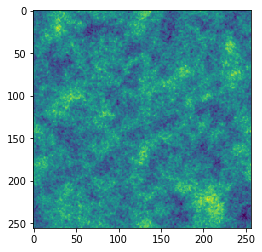

In [160]:
plt.imshow(X.squeeze())

tensor(10.8846, device='cuda:0')
tensor(10.8554, device='cuda:0')
tensor(10.8285, device='cuda:0')
tensor(10.8035, device='cuda:0')
tensor(10.7793, device='cuda:0')
tensor(10.7553, device='cuda:0')
tensor(10.7319, device='cuda:0')
tensor(10.7089, device='cuda:0')
tensor(10.6862, device='cuda:0')
tensor(10.6633, device='cuda:0')
tensor(10.6405, device='cuda:0')
tensor(10.6180, device='cuda:0')
tensor(10.5959, device='cuda:0')
tensor(10.5742, device='cuda:0')
tensor(10.5527, device='cuda:0')
tensor(10.5313, device='cuda:0')
tensor(10.5099, device='cuda:0')
tensor(10.4887, device='cuda:0')
tensor(10.4679, device='cuda:0')
tensor(10.4473, device='cuda:0')
tensor(10.4270, device='cuda:0')
tensor(10.4069, device='cuda:0')
tensor(10.3868, device='cuda:0')
tensor(10.3671, device='cuda:0')
tensor(10.3476, device='cuda:0')
tensor(10.3285, device='cuda:0')
tensor(10.3096, device='cuda:0')
tensor(10.2910, device='cuda:0')
tensor(10.2728, device='cuda:0')
tensor(10.2547, device='cuda:0')
tensor(10.

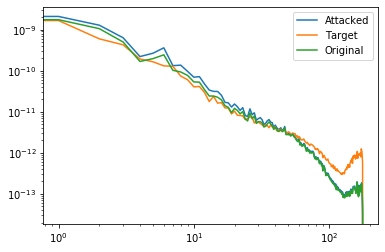

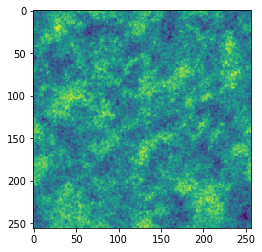

tensor(9.5092, device='cuda:0')
tensor(9.5042, device='cuda:0')
tensor(9.4995, device='cuda:0')
tensor(9.4950, device='cuda:0')
tensor(9.4906, device='cuda:0')
tensor(9.4864, device='cuda:0')
tensor(9.4823, device='cuda:0')
tensor(9.4782, device='cuda:0')
tensor(9.4741, device='cuda:0')
tensor(9.4701, device='cuda:0')
tensor(9.4662, device='cuda:0')
tensor(9.4625, device='cuda:0')
tensor(9.4587, device='cuda:0')
tensor(9.4551, device='cuda:0')
tensor(9.4516, device='cuda:0')
tensor(9.4481, device='cuda:0')
tensor(9.4448, device='cuda:0')
tensor(9.4416, device='cuda:0')
tensor(9.4384, device='cuda:0')
tensor(9.4354, device='cuda:0')
tensor(9.4324, device='cuda:0')
tensor(9.4295, device='cuda:0')
tensor(9.4267, device='cuda:0')
tensor(9.4239, device='cuda:0')
tensor(9.4212, device='cuda:0')
tensor(9.4185, device='cuda:0')
tensor(9.4160, device='cuda:0')
tensor(9.4134, device='cuda:0')
tensor(9.4110, device='cuda:0')
tensor(9.4087, device='cuda:0')
tensor(9.4063, device='cuda:0')
tensor(9

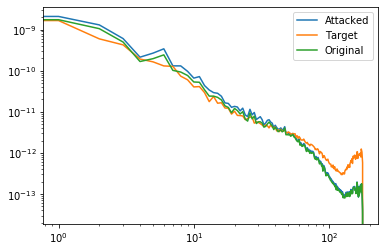

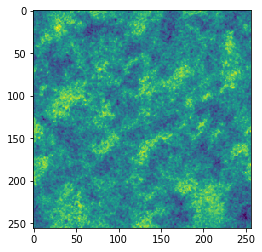

tensor(9.3215, device='cuda:0')
tensor(9.3207, device='cuda:0')
tensor(9.3199, device='cuda:0')
tensor(9.3199, device='cuda:0')
tensor(9.3193, device='cuda:0')
tensor(9.3197, device='cuda:0')
tensor(9.3193, device='cuda:0')
tensor(9.3183, device='cuda:0')
tensor(9.3174, device='cuda:0')
tensor(9.3176, device='cuda:0')
tensor(9.3168, device='cuda:0')
tensor(9.3162, device='cuda:0')
tensor(9.3161, device='cuda:0')
tensor(9.3158, device='cuda:0')
tensor(9.3154, device='cuda:0')
tensor(9.3149, device='cuda:0')
tensor(9.3144, device='cuda:0')
tensor(9.3143, device='cuda:0')
tensor(9.3139, device='cuda:0')
tensor(9.3134, device='cuda:0')
tensor(9.3131, device='cuda:0')
tensor(9.3128, device='cuda:0')
tensor(9.3125, device='cuda:0')
tensor(9.3121, device='cuda:0')
tensor(9.3117, device='cuda:0')
tensor(9.3114, device='cuda:0')
tensor(9.3111, device='cuda:0')
tensor(9.3107, device='cuda:0')
tensor(9.3104, device='cuda:0')
tensor(9.3101, device='cuda:0')
tensor(9.3097, device='cuda:0')
tensor(9

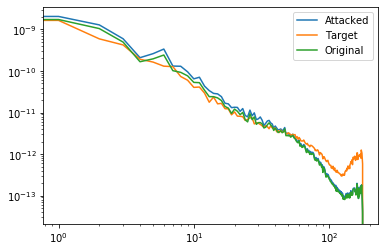

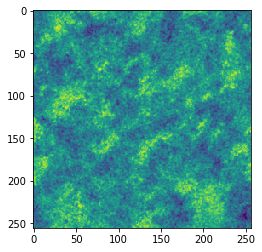

tensor(9.2867, device='cuda:0')
tensor(9.2869, device='cuda:0')
tensor(9.2888, device='cuda:0')
tensor(9.2865, device='cuda:0')
tensor(9.2876, device='cuda:0')
tensor(9.2887, device='cuda:0')
tensor(9.2894, device='cuda:0')
tensor(9.2898, device='cuda:0')
tensor(9.2899, device='cuda:0')
tensor(9.2897, device='cuda:0')
tensor(9.2893, device='cuda:0')
tensor(9.2887, device='cuda:0')
tensor(9.2880, device='cuda:0')
tensor(9.2871, device='cuda:0')
tensor(9.2863, device='cuda:0')
tensor(9.2856, device='cuda:0')
tensor(9.2850, device='cuda:0')
tensor(9.2848, device='cuda:0')
tensor(9.2855, device='cuda:0')
tensor(9.2859, device='cuda:0')
tensor(9.2846, device='cuda:0')
tensor(9.2841, device='cuda:0')
tensor(9.2841, device='cuda:0')
tensor(9.2842, device='cuda:0')
tensor(9.2842, device='cuda:0')
tensor(9.2842, device='cuda:0')
tensor(9.2841, device='cuda:0')
tensor(9.2839, device='cuda:0')
tensor(9.2836, device='cuda:0')
tensor(9.2833, device='cuda:0')
tensor(9.2829, device='cuda:0')
tensor(9

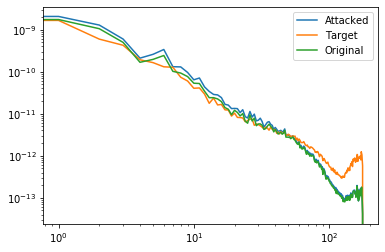

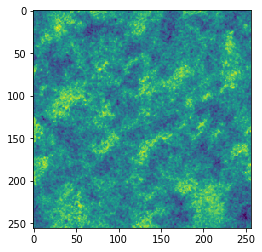

tensor(9.2635, device='cuda:0')
tensor(9.2634, device='cuda:0')
tensor(9.2641, device='cuda:0')
tensor(9.2629, device='cuda:0')
tensor(9.2633, device='cuda:0')
tensor(9.2636, device='cuda:0')
tensor(9.2635, device='cuda:0')
tensor(9.2631, device='cuda:0')
tensor(9.2625, device='cuda:0')
tensor(9.2618, device='cuda:0')
tensor(9.2613, device='cuda:0')
tensor(9.2612, device='cuda:0')
tensor(9.2615, device='cuda:0')
tensor(9.2609, device='cuda:0')
tensor(9.2603, device='cuda:0')
tensor(9.2601, device='cuda:0')
tensor(9.2600, device='cuda:0')
tensor(9.2599, device='cuda:0')
tensor(9.2597, device='cuda:0')
tensor(9.2594, device='cuda:0')
tensor(9.2590, device='cuda:0')
tensor(9.2586, device='cuda:0')
tensor(9.2584, device='cuda:0')
tensor(9.2582, device='cuda:0')
tensor(9.2581, device='cuda:0')
tensor(9.2577, device='cuda:0')
tensor(9.2574, device='cuda:0')
tensor(9.2571, device='cuda:0')
tensor(9.2569, device='cuda:0')
tensor(9.2567, device='cuda:0')
tensor(9.2565, device='cuda:0')
tensor(9

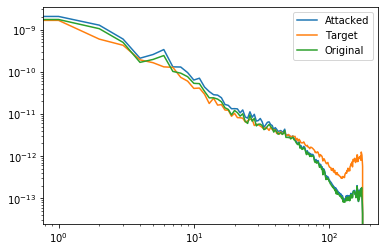

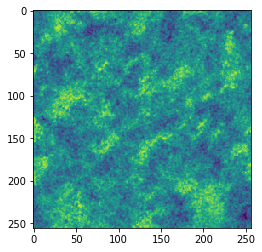

tensor(9.2442, device='cuda:0')
tensor(9.2442, device='cuda:0')
tensor(9.2440, device='cuda:0')
tensor(9.2440, device='cuda:0')
tensor(9.2437, device='cuda:0')
tensor(9.2437, device='cuda:0')
tensor(9.2434, device='cuda:0')
tensor(9.2433, device='cuda:0')
tensor(9.2432, device='cuda:0')
tensor(9.2430, device='cuda:0')
tensor(9.2429, device='cuda:0')
tensor(9.2428, device='cuda:0')
tensor(9.2426, device='cuda:0')
tensor(9.2425, device='cuda:0')
tensor(9.2424, device='cuda:0')
tensor(9.2422, device='cuda:0')
tensor(9.2421, device='cuda:0')
tensor(9.2420, device='cuda:0')
tensor(9.2418, device='cuda:0')
tensor(9.2417, device='cuda:0')
tensor(9.2416, device='cuda:0')
tensor(9.2414, device='cuda:0')
tensor(9.2413, device='cuda:0')
tensor(9.2412, device='cuda:0')
tensor(9.2410, device='cuda:0')
tensor(9.2409, device='cuda:0')
tensor(9.2407, device='cuda:0')
tensor(9.2406, device='cuda:0')
tensor(9.2405, device='cuda:0')
tensor(9.2403, device='cuda:0')
tensor(9.2402, device='cuda:0')
tensor(9

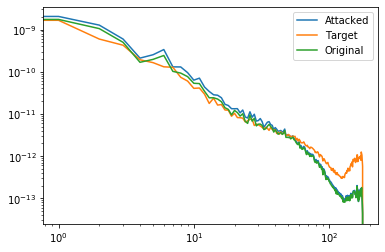

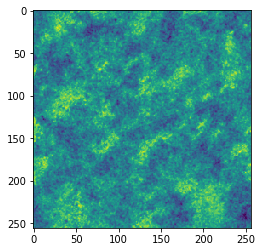

tensor(9.2312, device='cuda:0')
tensor(9.2313, device='cuda:0')
tensor(9.2314, device='cuda:0')
tensor(9.2311, device='cuda:0')
tensor(9.2312, device='cuda:0')
tensor(9.2311, device='cuda:0')
tensor(9.2309, device='cuda:0')
tensor(9.2308, device='cuda:0')
tensor(9.2308, device='cuda:0')
tensor(9.2308, device='cuda:0')
tensor(9.2306, device='cuda:0')
tensor(9.2305, device='cuda:0')
tensor(9.2305, device='cuda:0')
tensor(9.2304, device='cuda:0')
tensor(9.2303, device='cuda:0')
tensor(9.2302, device='cuda:0')
tensor(9.2302, device='cuda:0')
tensor(9.2301, device='cuda:0')
tensor(9.2301, device='cuda:0')
tensor(9.2300, device='cuda:0')
tensor(9.2299, device='cuda:0')
tensor(9.2298, device='cuda:0')
tensor(9.2298, device='cuda:0')
tensor(9.2297, device='cuda:0')
tensor(9.2296, device='cuda:0')
tensor(9.2295, device='cuda:0')
tensor(9.2295, device='cuda:0')
tensor(9.2294, device='cuda:0')
tensor(9.2293, device='cuda:0')
tensor(9.2292, device='cuda:0')
tensor(9.2292, device='cuda:0')
tensor(9

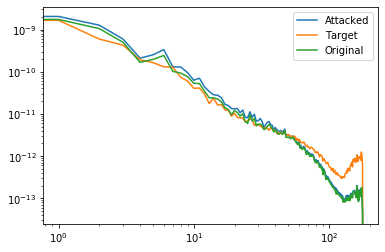

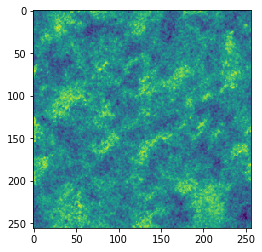

tensor(9.2255, device='cuda:0')
tensor(9.2255, device='cuda:0')
tensor(9.2254, device='cuda:0')
tensor(9.2254, device='cuda:0')
tensor(9.2253, device='cuda:0')
tensor(9.2253, device='cuda:0')
tensor(9.2252, device='cuda:0')
tensor(9.2252, device='cuda:0')
tensor(9.2251, device='cuda:0')
tensor(9.2251, device='cuda:0')
tensor(9.2251, device='cuda:0')
tensor(9.2250, device='cuda:0')
tensor(9.2250, device='cuda:0')
tensor(9.2249, device='cuda:0')
tensor(9.2249, device='cuda:0')
tensor(9.2248, device='cuda:0')
tensor(9.2248, device='cuda:0')
tensor(9.2247, device='cuda:0')
tensor(9.2247, device='cuda:0')
tensor(9.2247, device='cuda:0')
tensor(9.2246, device='cuda:0')
tensor(9.2246, device='cuda:0')
tensor(9.2245, device='cuda:0')
tensor(9.2245, device='cuda:0')
tensor(9.2244, device='cuda:0')
tensor(9.2244, device='cuda:0')
tensor(9.2243, device='cuda:0')
tensor(9.2243, device='cuda:0')
tensor(9.2242, device='cuda:0')
tensor(9.2242, device='cuda:0')
tensor(9.2241, device='cuda:0')
tensor(9

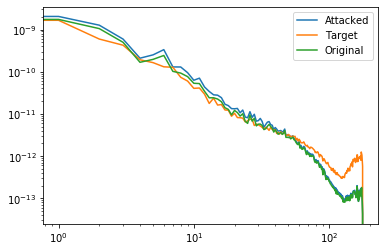

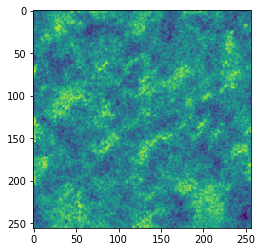

tensor(9.2216, device='cuda:0')
tensor(9.2217, device='cuda:0')
tensor(9.2218, device='cuda:0')
tensor(9.2216, device='cuda:0')
tensor(9.2216, device='cuda:0')
tensor(9.2216, device='cuda:0')
tensor(9.2215, device='cuda:0')
tensor(9.2215, device='cuda:0')
tensor(9.2215, device='cuda:0')
tensor(9.2215, device='cuda:0')
tensor(9.2214, device='cuda:0')
tensor(9.2214, device='cuda:0')
tensor(9.2214, device='cuda:0')
tensor(9.2214, device='cuda:0')
tensor(9.2213, device='cuda:0')
tensor(9.2213, device='cuda:0')
tensor(9.2213, device='cuda:0')
tensor(9.2213, device='cuda:0')
tensor(9.2213, device='cuda:0')
tensor(9.2212, device='cuda:0')
tensor(9.2212, device='cuda:0')
tensor(9.2212, device='cuda:0')
tensor(9.2212, device='cuda:0')
tensor(9.2211, device='cuda:0')
tensor(9.2211, device='cuda:0')
tensor(9.2211, device='cuda:0')
tensor(9.2211, device='cuda:0')
tensor(9.2211, device='cuda:0')
tensor(9.2210, device='cuda:0')
tensor(9.2210, device='cuda:0')
tensor(9.2210, device='cuda:0')
tensor(9

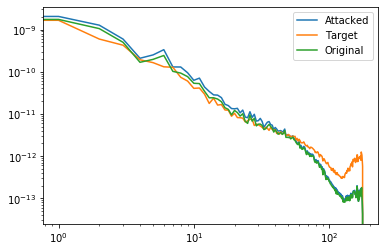

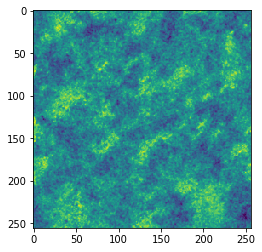

tensor(9.2197, device='cuda:0')
tensor(9.2198, device='cuda:0')
tensor(9.2198, device='cuda:0')
tensor(9.2197, device='cuda:0')
tensor(9.2197, device='cuda:0')
tensor(9.2197, device='cuda:0')
tensor(9.2197, device='cuda:0')
tensor(9.2197, device='cuda:0')
tensor(9.2196, device='cuda:0')
tensor(9.2196, device='cuda:0')
tensor(9.2196, device='cuda:0')
tensor(9.2196, device='cuda:0')
tensor(9.2196, device='cuda:0')
tensor(9.2196, device='cuda:0')
tensor(9.2196, device='cuda:0')
tensor(9.2195, device='cuda:0')
tensor(9.2195, device='cuda:0')
tensor(9.2195, device='cuda:0')
tensor(9.2195, device='cuda:0')
tensor(9.2195, device='cuda:0')
tensor(9.2195, device='cuda:0')
tensor(9.2195, device='cuda:0')
tensor(9.2194, device='cuda:0')
tensor(9.2194, device='cuda:0')
tensor(9.2194, device='cuda:0')
tensor(9.2194, device='cuda:0')
tensor(9.2194, device='cuda:0')
tensor(9.2194, device='cuda:0')
tensor(9.2194, device='cuda:0')
tensor(9.2193, device='cuda:0')
tensor(9.2193, device='cuda:0')
tensor(9

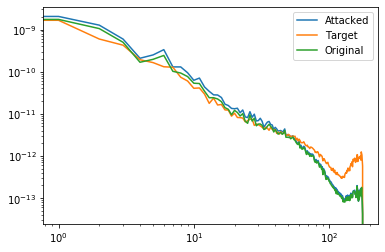

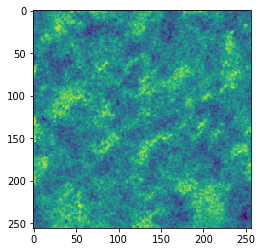

tensor(9.2184, device='cuda:0')
tensor(9.2184, device='cuda:0')
tensor(9.2184, device='cuda:0')
tensor(9.2184, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2183, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2182, device='cuda:0')
tensor(9.2181, device='cuda:0')
tensor(9.2181, device='cuda:0')
tensor(9.2181, device='cuda:0')
tensor(9.2181, device='cuda:0')
tensor(9.2181, device='cuda:0')
tensor(9

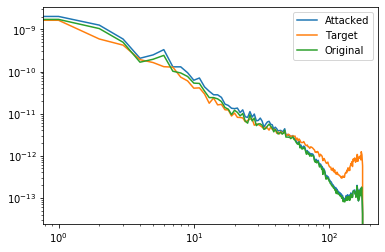

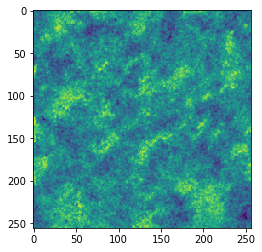

tensor(9.2175, device='cuda:0')
tensor(9.2175, device='cuda:0')
tensor(9.2175, device='cuda:0')
tensor(9.2175, device='cuda:0')
tensor(9.2175, device='cuda:0')
tensor(9.2175, device='cuda:0')
tensor(9.2175, device='cuda:0')
tensor(9.2175, device='cuda:0')
tensor(9.2175, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2174, device='cuda:0')
tensor(9.2173, device='cuda:0')
tensor(9.2173, device='cuda:0')
tensor(9.2173, device='cuda:0')
tensor(9.2173, device='cuda:0')
tensor(9.2173, device='cuda:0')
tensor(9.2173, device='cuda:0')
tensor(9.2173, device='cuda:0')
tensor(9.2173, device='cuda:0')
tensor(9

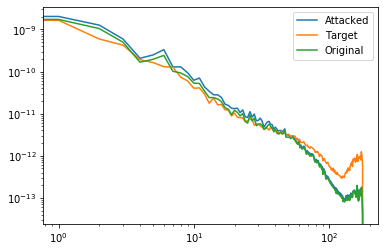

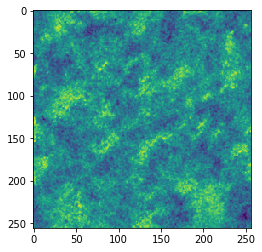

tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2169, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9.2168, device='cuda:0')
tensor(9

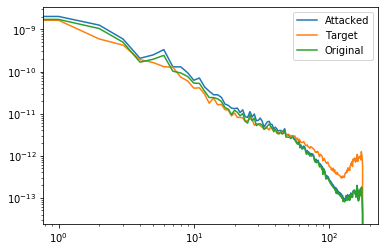

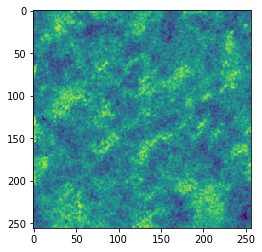

tensor(9.2166, device='cuda:0')
tensor(9.2166, device='cuda:0')
tensor(9.2166, device='cuda:0')
tensor(9.2166, device='cuda:0')
tensor(9.2166, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9.2165, device='cuda:0')
tensor(9

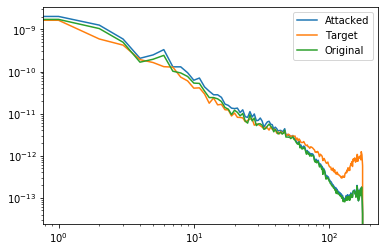

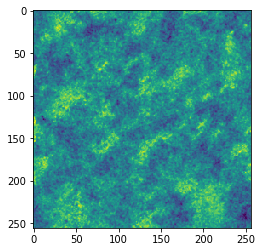

tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9.2163, device='cuda:0')
tensor(9

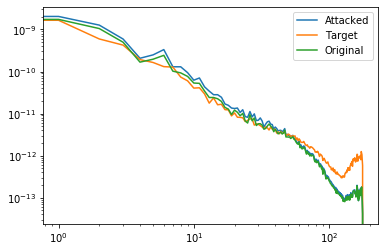

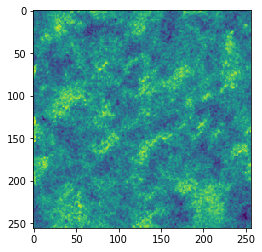

tensor(9.2162, device='cuda:0')
tensor(9.2162, device='cuda:0')
tensor(9.2162, device='cuda:0')
tensor(9.2162, device='cuda:0')
tensor(9.2162, device='cuda:0')
tensor(9.2162, device='cuda:0')
tensor(9.2162, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9.2161, device='cuda:0')
tensor(9

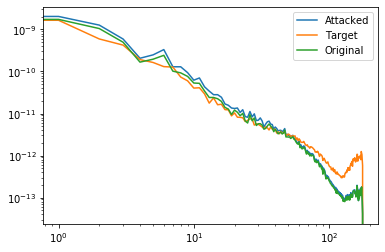

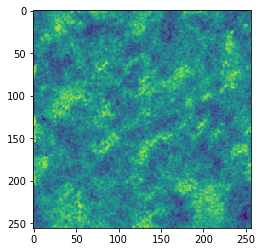

tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9

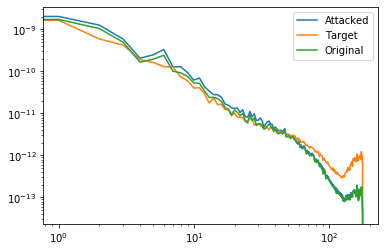

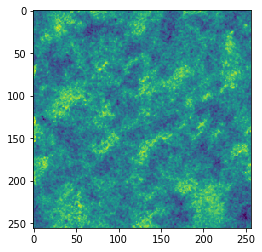

tensor(9.2159, device='cuda:0')
tensor(9.2160, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9

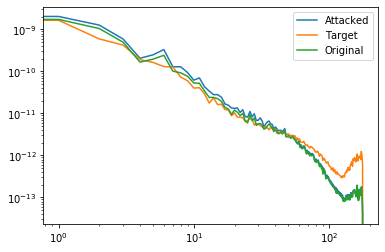

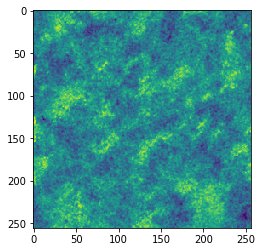

tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9.2159, device='cuda:0')
tensor(9

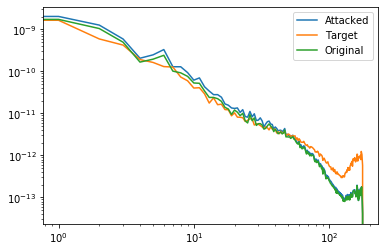

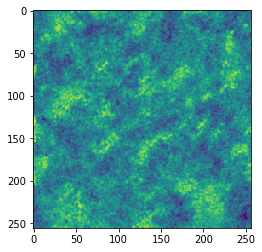

tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9

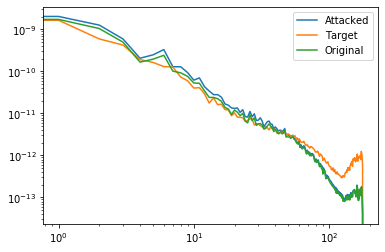

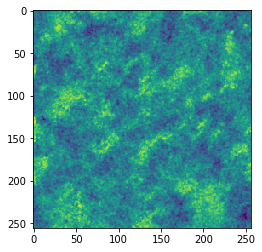

tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9

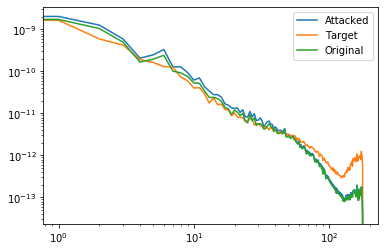

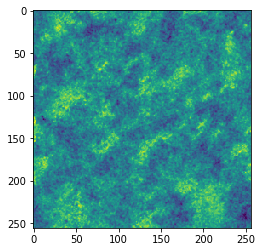

tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9.2158, device='cuda:0')
tensor(9

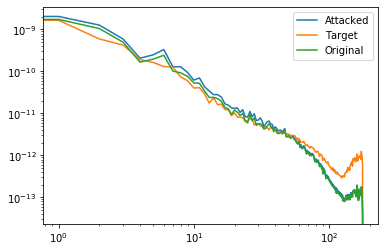

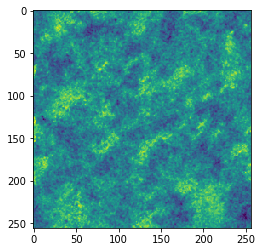

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

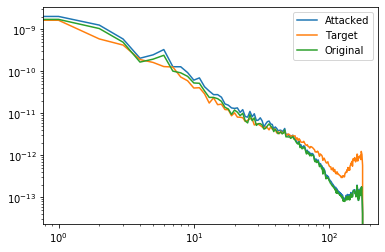

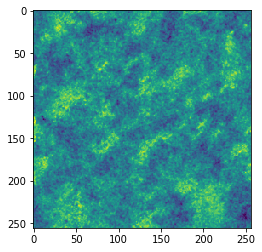

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

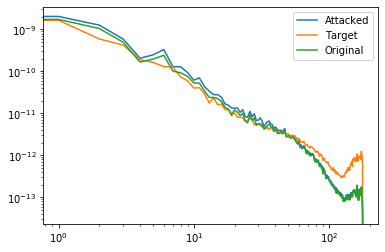

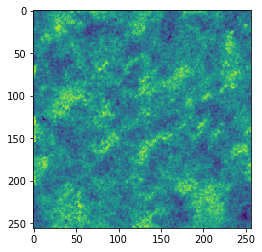

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

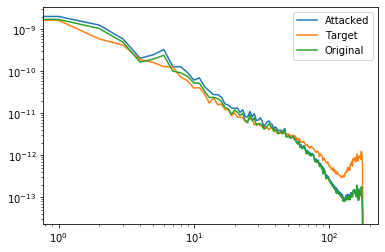

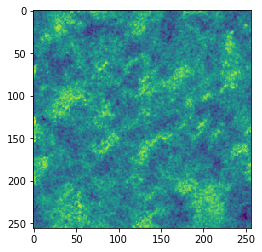

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

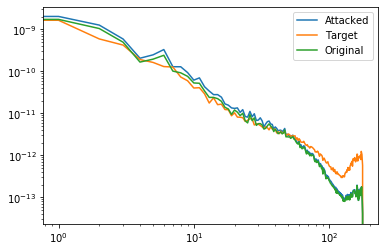

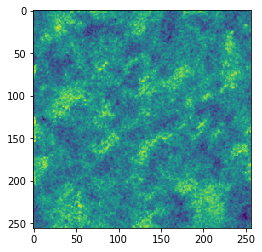

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

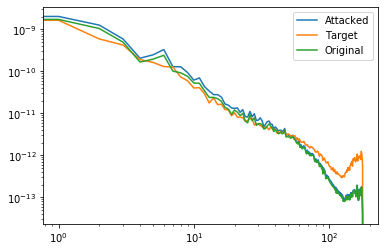

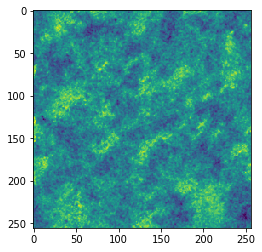

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

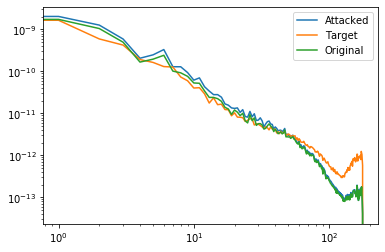

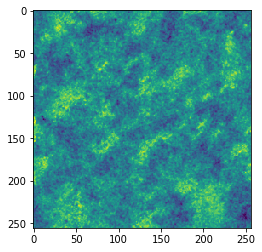

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

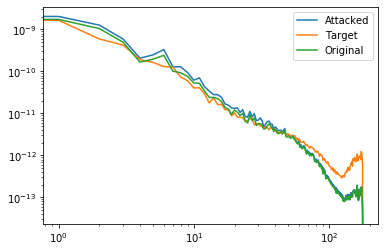

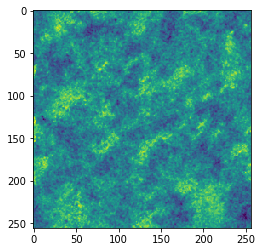

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

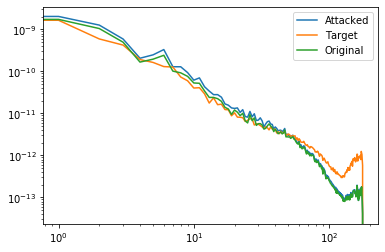

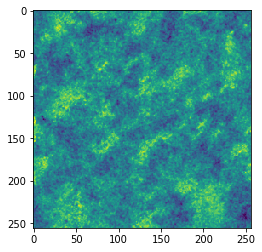

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

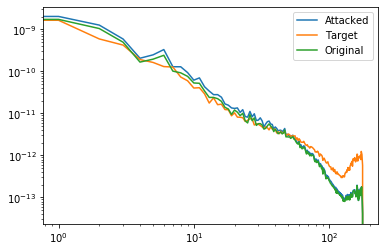

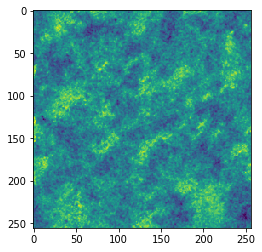

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

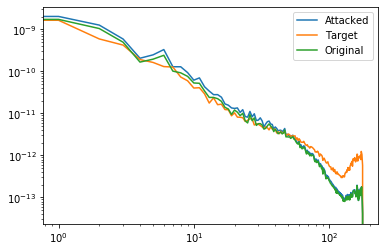

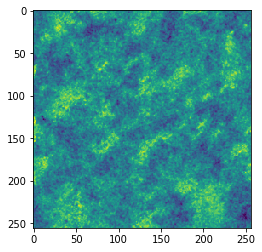

tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9.2157, device='cuda:0')
tensor(9

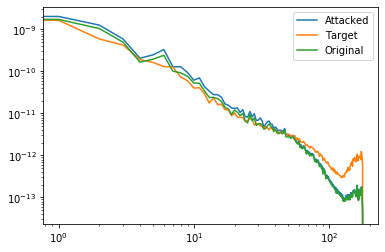

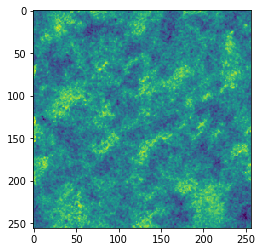

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

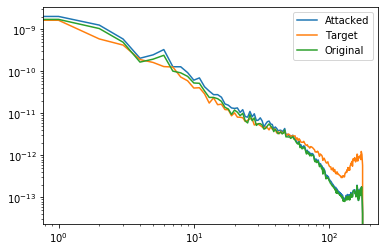

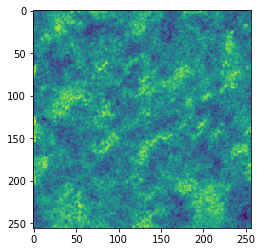

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

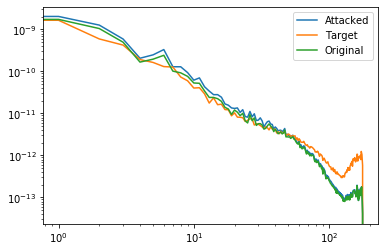

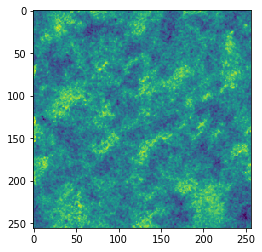

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

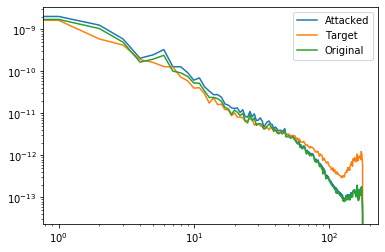

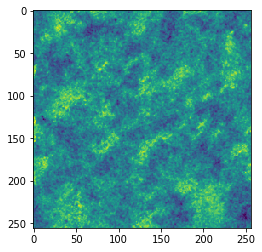

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

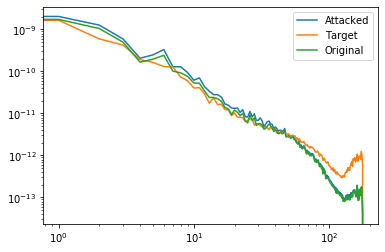

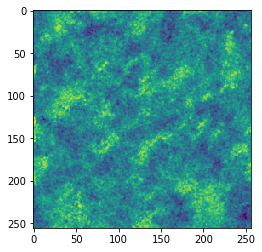

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

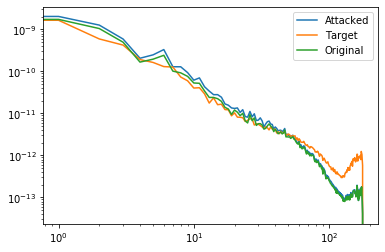

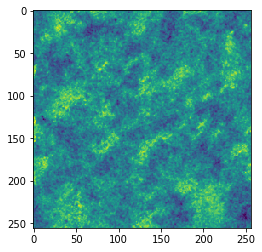

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

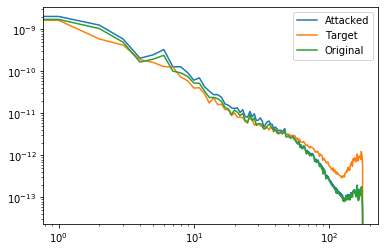

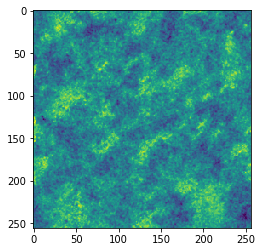

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

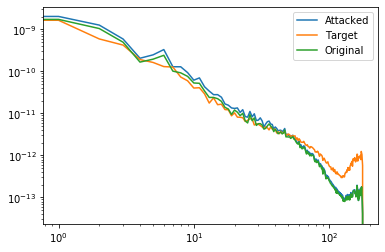

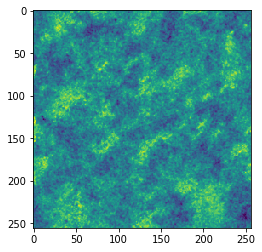

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

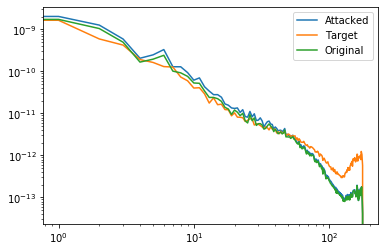

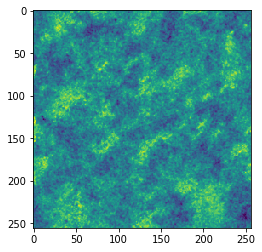

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

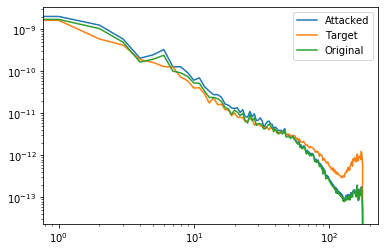

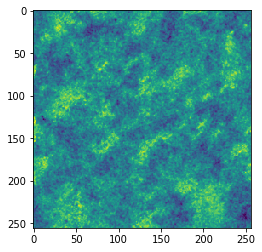

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

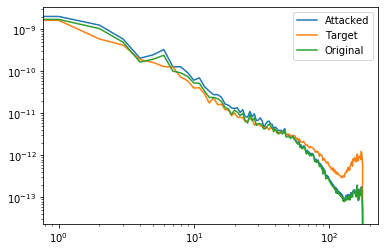

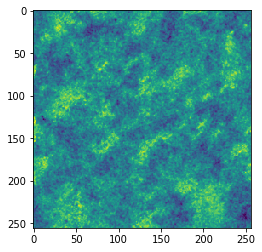

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

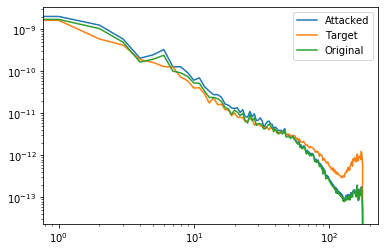

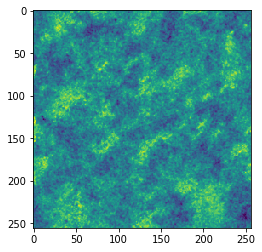

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

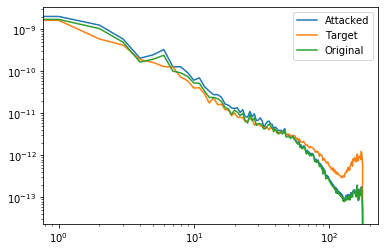

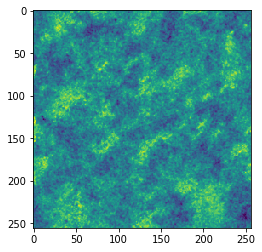

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

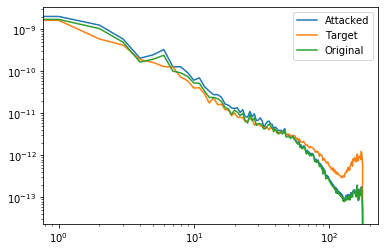

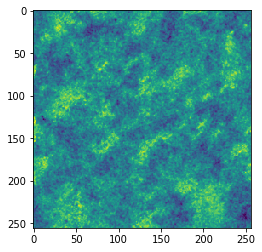

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

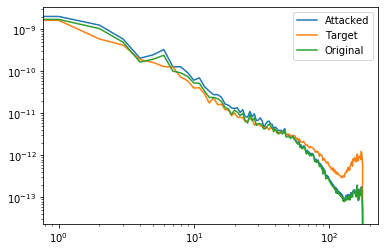

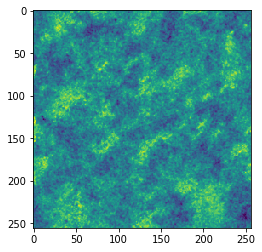

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

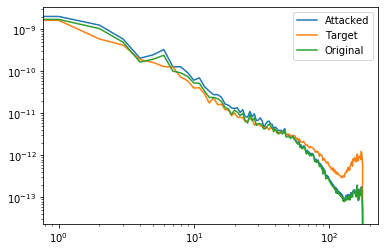

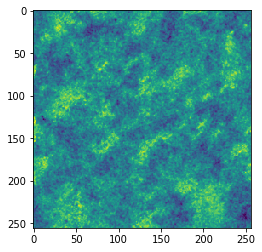

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

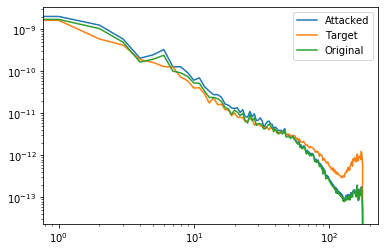

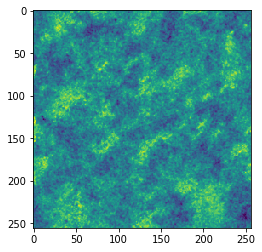

tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9.2156, device='cuda:0')
tensor(9

In [163]:
X_robust, init_embed, robust_embed = compute_robust_map(model,\
                                  torch.Tensor(X).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(targ_X).reshape((1, shape[0], shape[1])) )#,\

In [164]:
X_robust = X_robust.to('cpu').detach().numpy().squeeze()
init_embed = init_embed.to('cpu').detach().numpy().squeeze()
robust_embed = robust_embed.to('cpu').detach().numpy().squeeze()

In [165]:
def get_embedding_2(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#
############# UNCOMMENT ME ################
    x = model.init_conv(x)

    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)
    
    return x

In [166]:
print(np.linalg.norm(init_embed-robust_embed))

9.202345


In [167]:
X_robust.max(), X.max()

(0.17816463, 0.17894402685005995)

In [168]:
vmin = min(X.min(), targ_X.min())
vmax = max(X.max(), targ_X.max())

In [169]:
target_Y

array([[0.350059, 0.946085]])

In [170]:
model(scattering(torch.Tensor(targ_X.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.34281838, 0.9493489 ]], dtype=float32)

In [171]:
model(scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.30751157, 0.88906306]], dtype=float32)

In [172]:
model(scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.29125974, 0.85548884]], dtype=float32)

In [173]:
orig_s = scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
robust_s = scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
targ_s = scattering(torch.Tensor(targ_X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()

In [174]:
np.linalg.norm(orig_s-targ_s), np.linalg.norm(robust_s-targ_s)

(2.5230486, 2.641897)

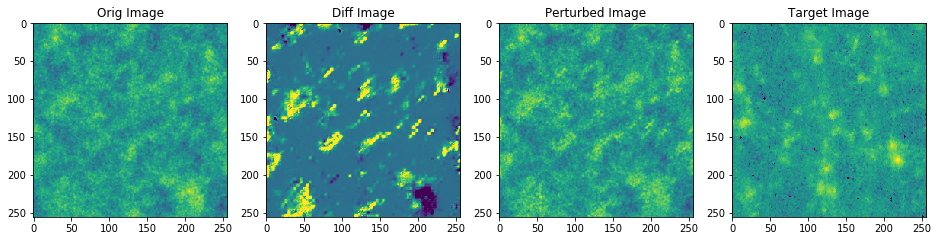

In [179]:
fig = plt.figure(figsize = (16,4))
plt.subplot(141)
plt.title('Orig Image')
plt.imshow(X.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(142)
plt.title('Diff Image')
plt.imshow(X_robust.squeeze()-X.squeeze() , vmin = -0.03*vmin, vmax= 0.03*vmax)
plt.subplot(143)
plt.title('Perturbed Image')
plt.imshow(X_robust.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(144)
plt.title('Target Image')
plt.imshow(targ_X.squeeze(), vmin = vmin, vmax=vmax)

(3659,)
(13997,)
(3583,)


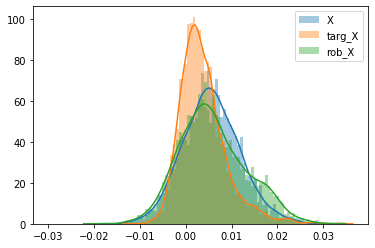

In [182]:
size = 1
bins = np.linspace(-0.03, 0.03, 100)
orig_peaks = count_peaks(X.squeeze()- X.mean(), size = size)
print(orig_peaks.shape)
sns.distplot(orig_peaks,label = 'X', bins = bins);
targ_peaks = count_peaks(gaussian_filter(targ_X.squeeze()- targ_X.mean(), smooth), size = size)
print(targ_peaks.shape)
sns.distplot(targ_peaks,label = "targ_X", bins = bins)
rob_peaks = count_peaks(X_robust.squeeze()-X_robust.mean(), size = size)
print(rob_peaks.shape)
sns.distplot(rob_peaks,label = 'rob_X', bins = bins)
plt.legend(loc = 'best');

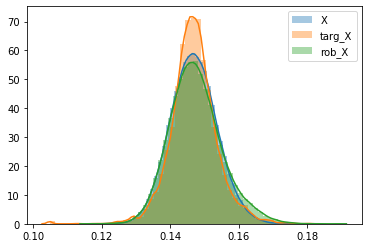

In [46]:
sns.distplot(X.flatten(), label = 'X')
sns.distplot(gaussian_filter(targ_X.flatten(), smooth), label = 'targ_X')
sns.distplot(X_robust.flatten(), label = 'rob_X')
plt.legend(loc='best')

---

In [47]:
attacked_ps = image_ps(X_robust.squeeze())
target_ps = image_ps(gaussian_filter(targ_X.squeeze(), smooth))
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_robust- X.squeeze()).squeeze())

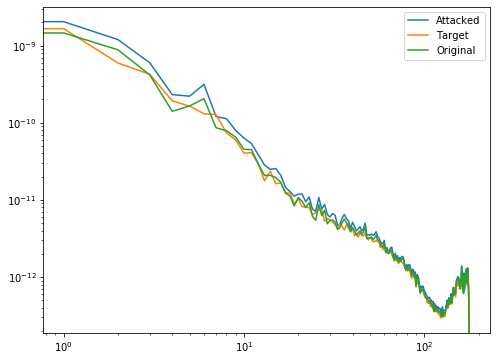

In [48]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();